In [1]:
from google.colab import files


uploaded = files.upload()

Saving pizza_sales_cleaned (1).csv to pizza_sales_cleaned (1).csv
Saving Pizza_ingredients.csv to Pizza_ingredients.csv


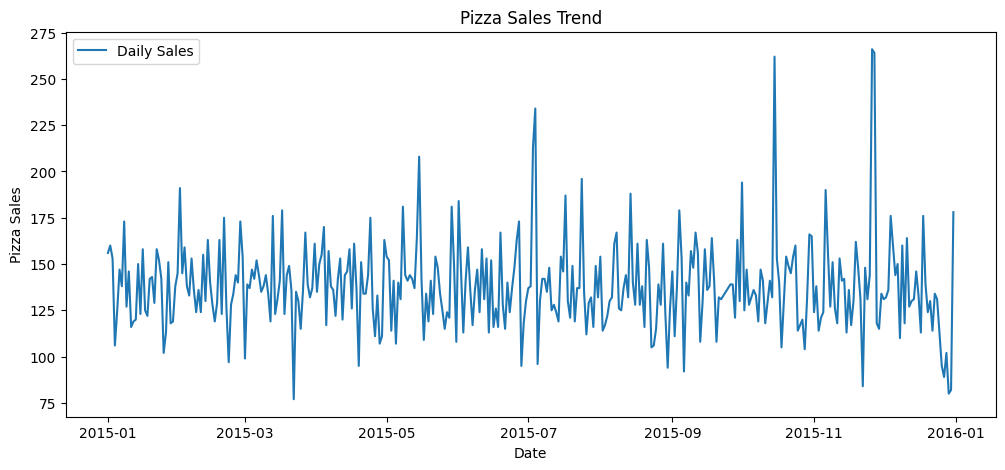

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeducitsr/b14ezps2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeducitsr/_56iqmv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50697', 'data', 'file=/tmp/tmpeducitsr/b14ezps2.json', 'init=/tmp/tmpeducitsr/_56iqmv0.json', 'output', 'file=/tmp/tmpeducitsr/prophet_modelr44vvj1x/prophet_model-20250205120552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE (SARIMA): 0.35
MAPE (Prophet): 0.17
Purchase order saved successfully.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error


df_sales = pd.read_csv("pizza_sales_cleaned (1).csv", encoding="utf-8")
df_ingredients = pd.read_csv("Pizza_ingredients.csv", encoding="utf-8")


df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])


daily_sales = df_sales.groupby('order_date')['quantity'].sum().reset_index()

# Plot the sales trend
plt.figure(figsize=(12, 5))
plt.plot(daily_sales['order_date'], daily_sales['quantity'], label="Daily Sales")
plt.xlabel("Date")
plt.ylabel("Pizza Sales")
plt.title("Pizza Sales Trend")
plt.legend()
plt.show()

# Aggregate the exogenous variables by date (mean for numeric columns, mode for categorical ones)
df_sales_daily = df_sales.groupby('order_date').agg({
    'hour': 'mean',
    'revenue_per_pizza': 'mean',
    'weekday': 'first',
    'is_weekend': 'mean'
}).reset_index()


df_sales_daily['weekday'] = df_sales_daily['weekday'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

# SARIMA model
sarima_model = SARIMAX(daily_sales['quantity'],
                       order=(1,1,1), seasonal_order=(1,1,1,7),
                       exog=df_sales_daily[['hour', 'weekday', 'is_weekend', 'revenue_per_pizza']])

sarima_result = sarima_model.fit()


future_dates = pd.date_range(start=daily_sales['order_date'].max() + pd.Timedelta(days=1), periods=7, freq='D')


forecast_sarima = sarima_result.predict(start=len(daily_sales), end=len(daily_sales)+6, exog=df_sales_daily[['hour', 'weekday', 'is_weekend', 'revenue_per_pizza']].iloc[-7:])

# Prophet model
prophet_df = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})
prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
prophet.fit(prophet_df)


future = prophet.make_future_dataframe(periods=7)
forecast_prophet = prophet.predict(future)


actual = daily_sales['quantity'][-7:].values
predicted_sarima = forecast_sarima[:7]
predicted_prophet = forecast_prophet['yhat'][-7:].values

# Calculate MAPE for both models
mape_sarima = mean_absolute_percentage_error(actual, predicted_sarima)
mape_prophet = mean_absolute_percentage_error(actual, predicted_prophet)

print(f"MAPE (SARIMA): {mape_sarima:.2f}")
print(f"MAPE (Prophet): {mape_prophet:.2f}")


best_forecast = forecast_sarima if mape_sarima < mape_prophet else forecast_prophet['yhat'][:7].values

# Create the forecast dataframe
forecast_df = pd.DataFrame({"order_date": future_dates, "predicted_sales": np.round(best_forecast, 2)})

# Calculate the average sales per pizza
pizza_sales_avg = df_sales.groupby('pizza_name_id')['quantity'].mean().reset_index()
pizza_sales_avg.rename(columns={'quantity': 'avg_quantity'}, inplace=True)

# Merge forecast_df with pizza_sales_avg
forecast_df = forecast_df.assign(key=1).merge(pizza_sales_avg.assign(key=1), on='key').drop(columns=['key'])

forecast_df['pizza_sales_forecast'] = (forecast_df['predicted_sales'] *
                                       (forecast_df['avg_quantity'] / forecast_df['avg_quantity'].sum()))

# Merge forecast with the ingredient data
forecast_df = forecast_df.merge(df_ingredients, on='pizza_name_id', how='inner')
forecast_df.dropna(subset=['pizza_ingredients'], inplace=True)

# Normalize the pizza sales forecast and calculate ingredient demand
forecast_df['pizza_sales_forecast'] /= forecast_df['pizza_sales_forecast'].sum()
forecast_df['pizza_sales_forecast'] *= forecast_df['predicted_sales'].sum()

# Calculate ingredient demand in grams
forecast_df['ingredient_demand'] = np.round(forecast_df['pizza_sales_forecast'] * forecast_df['Items_Qty_In_Grams'], 2)


final_purchase_order = forecast_df.groupby(['pizza_ingredients'])['ingredient_demand'].sum().reset_index()
final_purchase_order['ingredient_demand'] = final_purchase_order['ingredient_demand'].round(2)


final_purchase_order.to_csv("purchase_order.csv", index=False)

print("Purchase order saved successfully.")




In [5]:
from google.colab import files
files.download("purchase_order.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>